In [49]:
# Notes to recompute power

# List CPMA pvals
# cat /gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_0/Beta_0/Simulation_*/CPMA/gene-snp-eqtl_cpma_pvalues_fixed | grep -v snp | cut -f 4

# Get best pairwise SNPxgene pvals
# for f in $(ls /gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_30/Beta_1/Simulation_*/CPMA/gene-snp-eqtl); do cat $f | grep -v gene | datamash min 5; done

#### First run below before running this notebook! ###
# Script ./compile_pvals.sh compiles the pvals so we can recompute power here

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [45]:
# Params and paths

targets = [ 5, 15, 20, 30, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
beta_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

sample_size = 500

In [50]:
import os

def GetPower(method, tar, value, sample_size, sigthresh, num_snps, num_genes):
    pfile = os.path.join("/storage/mgymrek/cpma/power/",
                        "_".join([method, str(sample_size), str(tar), value]) + ".pvals")
    pvals = [float(item.strip()) for item in open(pfile, "r").readlines()]
    thresh = 0 # need to set
    if method == "Pairwise":
        thresh = sigthresh/(num_snps*num_genes)
    if method == "CPMA" or method == "Mixture":
        thresh = sigthresh/(num_snps)
    return np.mean([item<thresh for item in pvals])
    
def compile_power(targets, beta_values, sample_size, method, sigthresh, num_snps, num_genes):
    all_powers = []
    for beta in beta_values:
        power = []
        for tar in targets:   
            value = str(beta).replace(".","")
            pw = GetPower(method, tar, value, sample_size, sigthresh, num_snps, num_genes)
            power.append(pw)
        all_powers.append(power)
    power_df = pd.DataFrame(all_powers, columns=targets, index=beta_values)
    return power_df

sigthresh = 0.05
num_snps = 10000
num_genes = 15000
power_cpma_df = compile_power(targets, beta_values, sample_size, 'CPMA',
                             sigthresh, num_snps, num_genes)
power_pairwise_df = compile_power(targets, beta_values, sample_size, 'Pairwise',
                             sigthresh, num_snps, num_genes)
power_cpmamix_df = compile_power(targets, beta_values, sample_size, 'Mixture',
                             sigthresh, num_snps, num_genes)

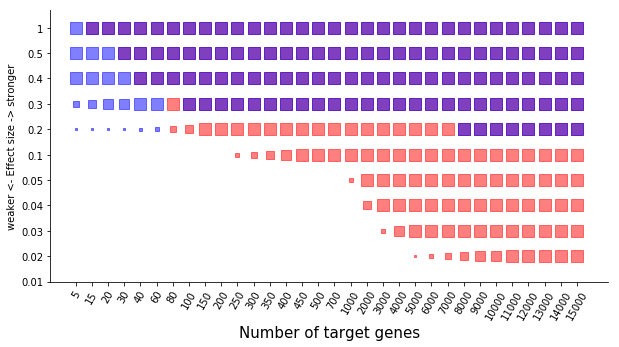

In [61]:
def DrawPoint(ax1, xval, yval, size, colors):
    if size > 0:
        for c in colors:
            ax1.scatter([xval], [yval], marker='s',
                   s=size, color=c, alpha=0.5)
    
def power_plot(power_dfs_dict, targets, beta_values):

    # First plot power
    size_scale = 1
    fig = plt.figure()
    fig.set_size_inches((10, 5))
    
    ax1 = fig.add_subplot(111)
    size = 150
    for xval in range(len(targets)):
        for yval in range(len(beta_values)):
            colors = []
            best_power = 0
            for method in power_dfs_dict.keys():
                power = power_dfs_dict[method]["power"][yval, xval]
                if power >best_power:
                    best_power = power
                    colors = [power_dfs_dict[method]["color"]]
                elif power == best_power: # if a tie, use both colors
                    best_power = power
                    colors.append(power_dfs_dict[method]["color"])
            DrawPoint(ax1, xval, yval, size*best_power, colors)
    ax1.set_xticks(range(len(targets)))
    ax1.set_xticklabels(targets, rotation=60)
    ax1.set_yticks(range(len(beta_values)))
    ax1.set_yticklabels(beta_values)
    ax1.set_xlabel("Number of target genes", size=15)
    ax1.set_ylabel("weaker <- Effect size -> stronger")
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
power_dfs_dict = {
    "CPMA": {"power": np.matrix(power_cpma_df), "color": "red"},
    "Pairwise": {"power": np.matrix(power_pairwise_df), "color": "blue"},
    #"CPMAMix": {"power": np.matrix(power_cpmamix_df), "color": "red"}    
}

power_plot(power_dfs_dict, targets, beta_values)